# Principles of Data Science

### Lecture 7: More common distributions and generating from distributions

_MPhil in Data Intensive Science_

**University of Cambridge**

<h2 style="color: blue">Matt Kenzie</h2>

[mk652@cam.ac.uk](mailto:mk652@cam.ac.uk)

## More common distributions and generating from distributions

- Today's lecture covers some more of the most common distributions and how we go about generating events from distributions

- Learning objectives:
    - Adding more distributions to your armoury (the exponential distribution, Bernstein polynomials, the chi-squared distribution)
    - Sums of p.d.f.s
    - Convolutions of p.d.f.s
    - Understand and be able to deploy and contrast different methods of simulation from distributions
    

## Recap

Last lecture we introduced

- The binomial distribution

$$ p(k; n, p) = \frac{n!}{k!(n-k)!} p^k (1-p)^{n-k} $$

- The Poisson distribution (limit of binomial as $n\to infty$ and $k$ fixed)

$$ p(k; \lambda) = \frac{e^{-\lambda} \lambda^k }{k!} $$

- The multivariate-normal distribution

$$ p(\vec{X}; \vec{\mu}, \mathbf{V}) = \frac{1}{(2\pi)^{n/2} \sqrt{|\mathbf{V}|}} \exp \left[ -\frac{1}{2} (\vec{X} - \vec{\mu})^{\text{T}} \mathbf{V}^{-1} (\vec{X}-\vec{\mu}) \right] $$


## The exponential decay distribution

<font color="green">*Hand written notes in lectures*</font>

- Discuss p.d.f and c.d.f
- Show relationship to the Poisson distribution

Text(0.5, 0, '$X$')

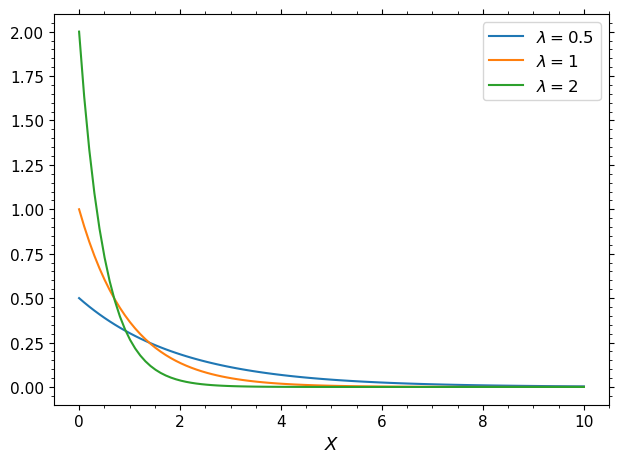

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../mphil.mplstyle')

from scipy.stats import expon

x = np.linspace(0,10,100)

for lb in [0.5,1,2]:
    plt.plot(x, expon.pdf(x,loc=0,scale=1/lb), label=f'$\lambda={lb}$')

plt.legend()
plt.xlabel('$X$')

## Polynomial distributions 

- Incredibly useful for flexibility (fitting when we don't *a priori* know a shape)
- But rather irritating because of their flexibility (they can go negative)
    - Recall 1st Kolmogorov, $P(X) \geq 0  \;\; \forall  \;\; X$
- Solved by polynomial in the Bernstein basis

<font color="green">*Hand written notes in lectures*</font>

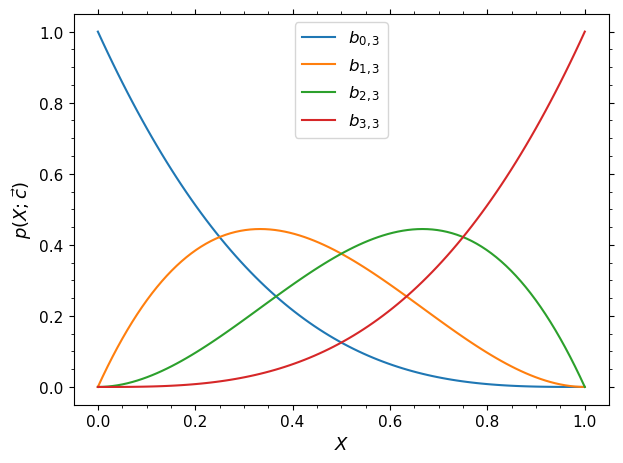

In [2]:
from scipy.special import binom # for binom coefficients

def bbpol(x, i, n):
    return binom(n,i) * x**i * (1-x)**(n-i)

x = np.linspace(0,1,100)

for i in range(4):
    plt.plot(x, bbpol(x, i,3), label=f'$b_{{{i},3}}$')
plt.xlabel('$X$')
plt.ylabel(r'$p(X; \vec{c})$')
plt.legend()

- Bernstein p.d.f.

$$ p(X; c_i) = \frac{n+1}{\sum c_i} \sum c_i b_{i,n} $$

In [3]:
def bernstein(x, pars):
    n = len(pars)-1
    N = (n+1) / np.sum(pars)
    px = np.zeros_like(x)
    for i in range(n+1):
        px += N * pars[i] * bbpol(x, i, n)
    return px
    

- Bernstein's have a **partition of unity**

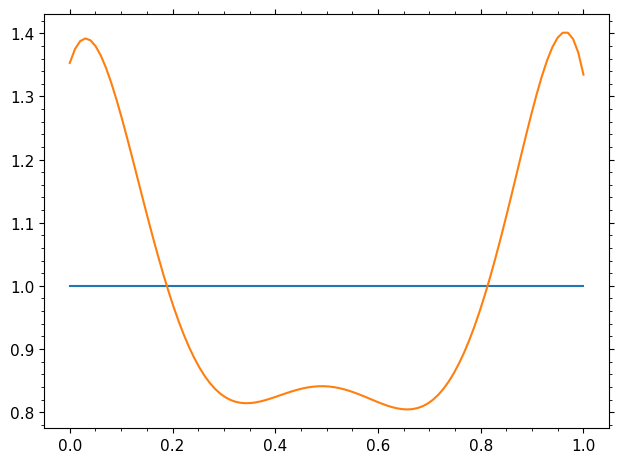

In [4]:
plt.plot( x, bernstein(x, [1,1,1,1]) )
ps = np.random.uniform(size=  10)
plt.plot( x, bernstein(x, ps) )

## Implementation in numpy.polyfit

- There is a nice implementation of polynomial fits included in [`numpy.polyfit`](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html)
- It will only fit the polynomial but is very handy


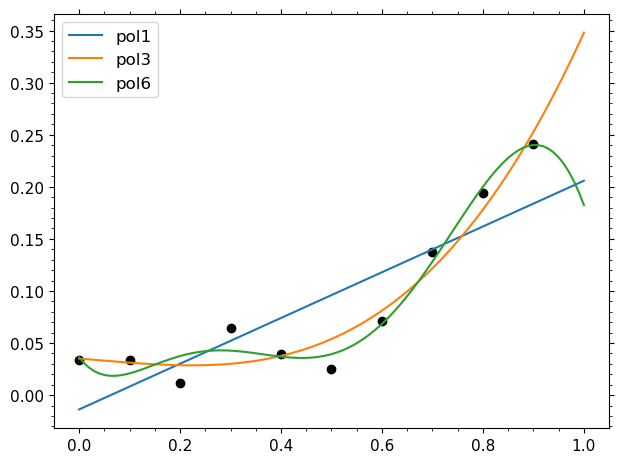

In [5]:
# uniform x points
x = np.arange(0,1,0.1)

# y relation
y = 0.5*x**2 - 0.2*x + 0.05

# add some random noise
y += np.random.normal(0,0.03, size=len(x))

# function to evaluate the poly from np.polyfit
def poly(x, pars):
    pars = np.flip(pars)
    res = np.zeros_like(x)
    for i, p in enumerate(pars):
        res += p*x**i
    return res
    
plt.scatter(x, y, c='k', marker='o')

xp = np.linspace(0,1,100)
for deg in [1, 3, 6]:
    ps = np.polyfit(x, y, deg)
    plt.plot( xp, poly(xp, ps), label=f'pol{deg}' )

plt.legend() 

## The chi-squared distribution

<font color="green">*Hand written notes in lectures*</font>

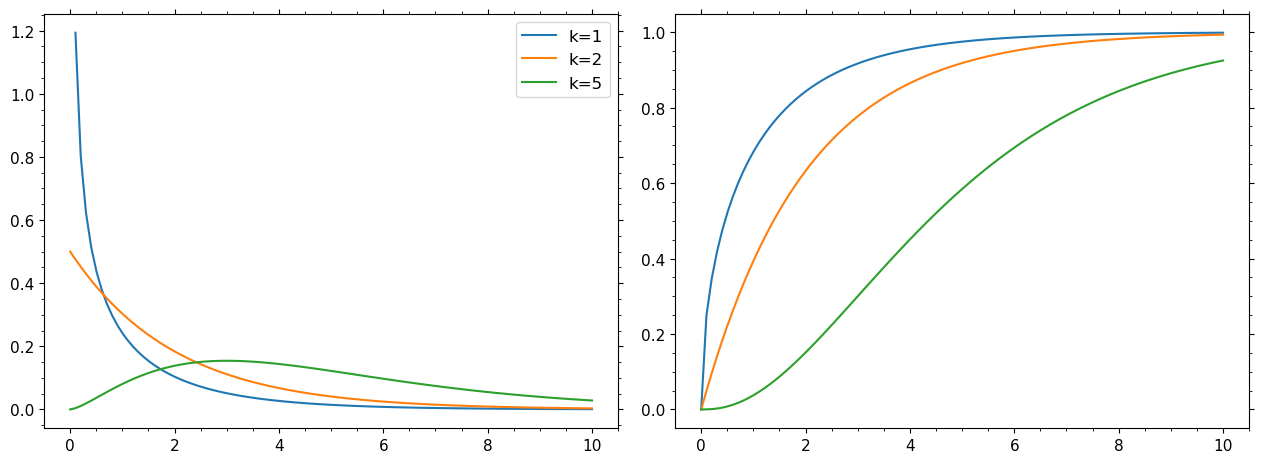

In [6]:
from scipy.stats import chi2

x = np.linspace(0,10,100)

fig, ax = plt.subplots(1,2, figsize=(12.8,4.8))

for k in [1,2,5]:
    ax[0].plot(x, chi2.pdf(x,k), label=f"k={k}")
    ax[1].plot(x, chi2.cdf(x,k), label=f"k={k}")

ax[0].legend()

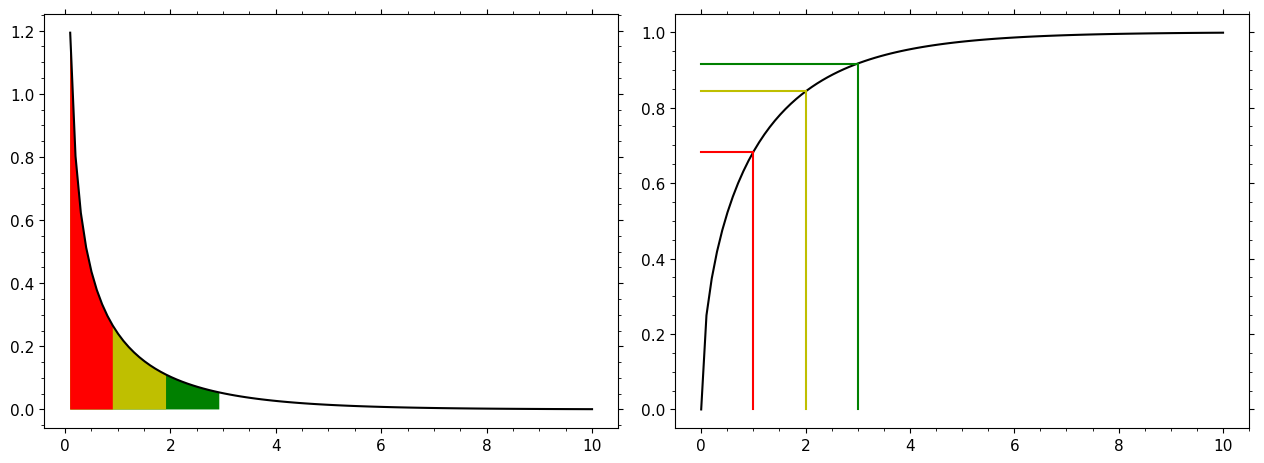

In [7]:
fig, ax = plt.subplots(1,2, figsize=(12.8,4.8))

ax[0].plot(x, chi2.pdf(x, 1), c='k')
ax[1].plot(x, chi2.cdf(x, 1), c='k')
for Z, col in zip([3,2,1], ['g','y','r']):
    ax[0].fill_between( x[x<Z], 0, chi2.pdf(x[x<Z],1), fc=col )
    ax[1].plot( [Z,Z], [0,chi2.cdf(Z,1)], c=col)
    ax[1].plot( [0,Z], [chi2.cdf(Z,1), chi2.cdf(Z,1)], c=col)

## Using the chi-squared to read off fractions contained within Z score


In [8]:
from tabulate import tabulate

# 1D
print( tabulate( zip( [1,2,3], [chi2.cdf(Z**2,1) for Z in [1,2,3] ] ) ) )
                                
# 2D 
print( tabulate( zip( [1,2,3], [chi2.cdf(Z**2,2) for Z in [1,2,3] ] ) ) )


-  --------
1  0.682689
2  0.9545
3  0.9973
-  --------
-  --------
1  0.393469
2  0.864665
3  0.988891
-  --------


# <font color="darkred">*Musical interlude...*</font>

## Building up distributions

- Can always build sums of p.d.f.s out of constituent parts (sometimes these are called *sum p.d.f.s*)
- E.g. could build a model consisting of <font color="red">*background*</font> (uniform distribution) and <font color="green">*signal*</font>
- Need parameters for each of the constituent shapes and additional parameters for the fraction of each component in the sum
- In this case:

$$ p(X; \vec{\theta}) = f N(X;  \mu, \sigma ) + (1-f) U(X) $$

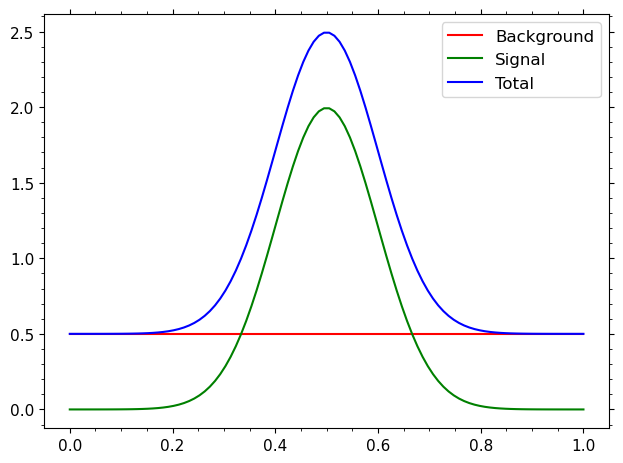

In [9]:
from scipy.stats import norm, uniform

mu = 0.5
sg = 0.1
f = 0.5

def bkg(x):
    return uniform.pdf(x)

def sig(x):
    return norm.pdf(x, mu, sg)

def tot(x):
    return f*sig(x) + (1-f)*bkg(x)

x = np.linspace(0,1,100)
plt.plot(x, (1-f)*bkg(x), c="r", label="Background")
plt.plot(x, f*sig(x), c="g", label="Signal")
plt.plot(x, tot(x), c="b", label="Total")
plt.legend()
    

## Convolutions of distributions

<font color="green">*Hand written notes in lectures*</font>

- Allows us to incorporate resolution on random variable measurement
- Measure the sum (or sometimes product) of two r.v.s
- Resolution is Gaussian *convolved* with the true "physics" pdf
- Often **very hard** to do analytically (requires numerical methods)


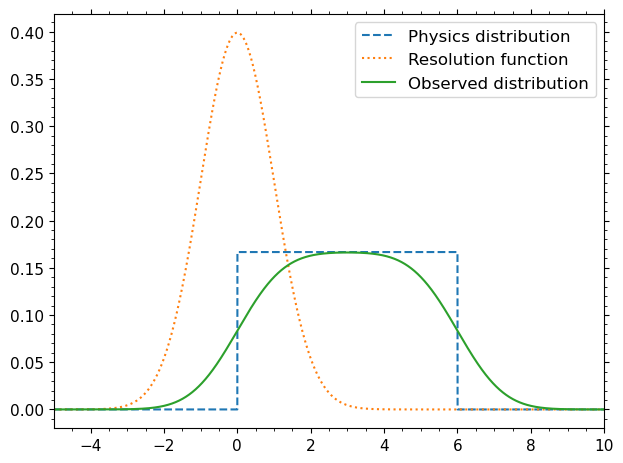

In [10]:
from scipy.signal import fftconvolve

uniform_pdf = uniform(loc=0, scale=6)
normal_pdf1 = norm(loc=0, scale=1)
normal_pdf2 = norm(loc=0, scale=0.3)
expon_pdf   = expon(loc=0,scale=1)

# convolution is done numerically
# need symmetric range around the center of the convolution
# and need a numerical accuracy term, delta
delta = 1e-4
x = np.arange(-20,20,delta)

# numerically compute pdfs
pdf1 = uniform_pdf.pdf(x)*delta
pdf2 = normal_pdf1.pdf(x)*delta
pdf3 = normal_pdf2.pdf(x)*delta
pdf4 = expon_pdf.pdf(x)*delta

# perform numerical convolution
conv_pdf1 = fftconvolve(pdf1, pdf2, mode='same')
conv_pdf2 = fftconvolve(pdf3, pdf4, mode='same')

plt.plot(x, pdf1/delta, ls='--', label='Physics distribution')
plt.plot(x, pdf2/delta, ls=':', label='Resolution function')
plt.plot(x, conv_pdf1/delta, label='Observed distribution')

plt.xlim(-5,10)
plt.legend()

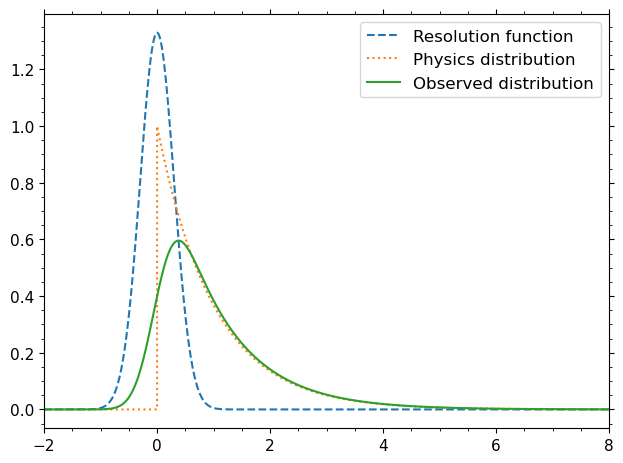

In [11]:
plt.plot(x, pdf3/delta, ls='--', label='Resolution function')
plt.plot(x, pdf4/delta, ls=':', label='Physics distribution')
plt.plot(x, conv_pdf2/delta, label='Observed distribution')

plt.xlim(-2,8)
plt.legend()

## Generating from distributions

- A vital part of the analysis toolkit is simulating events from distributions
- You have seen me do this several times already

In [12]:
x = np.random.uniform(-4, 4, size=5000)
n = np.random.normal(size=5000)

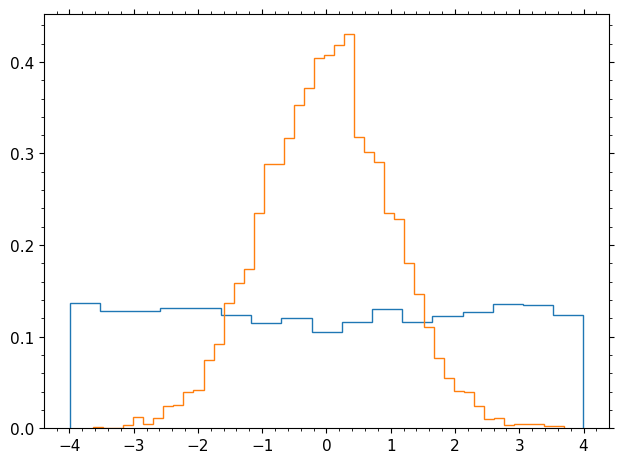

In [13]:
_ = plt.hist( x, bins='auto', density=True, histtype='step' )
_ = plt.hist( n, bins='auto', density=True, histtype='step' )


### The inverse c.d.f.

- p.d.f  $f(X)$ - probability as function of r.v. $X$
- c.d.f. $F(X)$ - percentage of distribution below $X$, from integral of p.d.f. 

$$ F(X) = \int_{-\infty}^{X} f(X) dX $$

- The inverse c.d.f. sometimes called the *percentage point function* (p.p.f.), gives mapping from a probability (in interval [0,1]) back to the r.v. $X$

$$ F^{-1}(p) = X $$



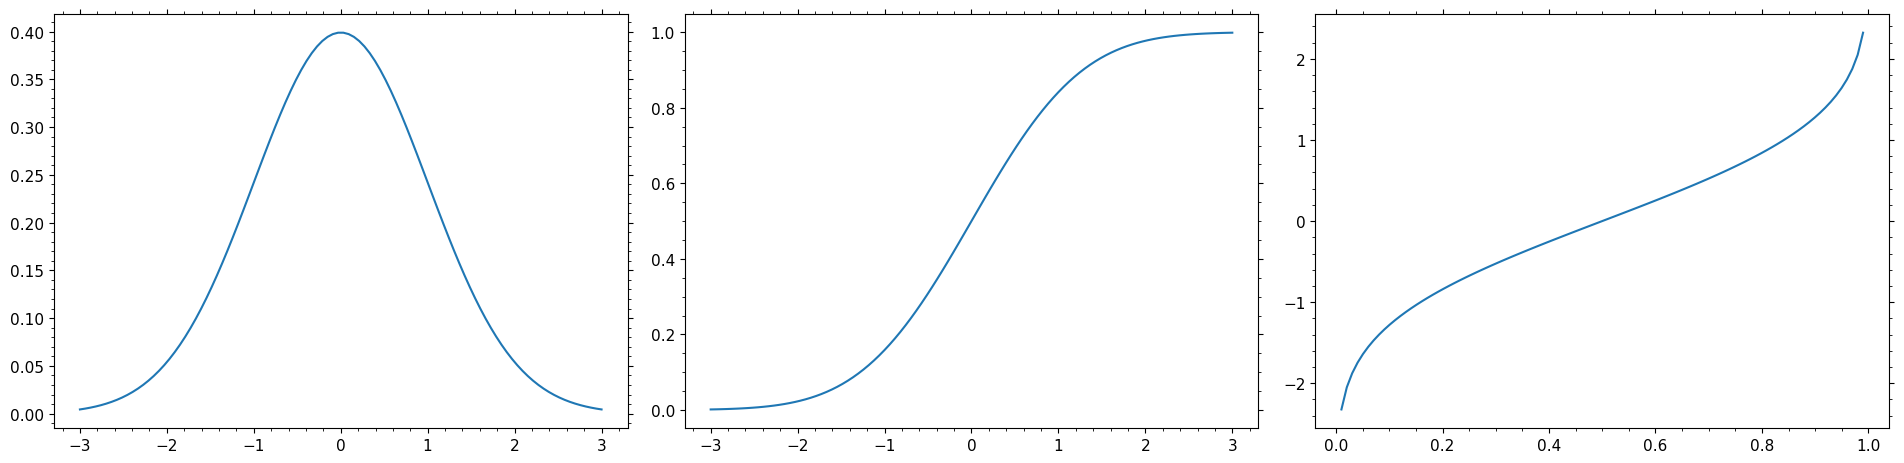

In [14]:
# normal distribution example

fig, ax = plt.subplots(1,3, figsize=(19.2,4.8))

x = np.linspace(-3,3,100)

ax[0].plot(x, norm.pdf(x) )

ax[1].plot(x, norm.cdf(x) )

p = np.linspace(0,1,100)

ax[2].plot(p, norm.ppf(p) )


## Sampling from distributions

- Consequently to generate *any* distribution we just need to generate a uniform random number
- I won't cover the details in these lectures but there are various resources out there
- Let's suffice to assume that this is relatively simple
- We can generate a uniform number in [0,1] and then use the p.p.f. to transform it back to the relevent distribution

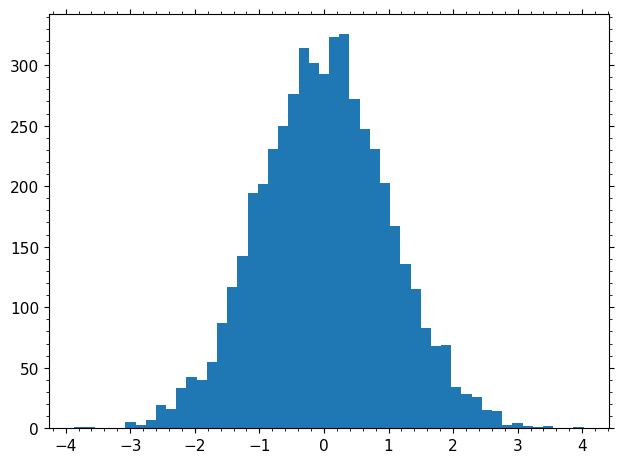

In [15]:
x = np.random.uniform(size=5000)

_ = plt.hist( norm.ppf(x), bins='auto' )

## The accept-reject method

- What if we don't know the p.p.f, but do know the p.d.f.
- Brute force approach is called **accept-reject**

    1. Generate random uniform number in $X$
    2. Generate random uniform number in $y$
    3. If $y < p(X)$ then **accept**
    3. If $y > p(X)$ then **reject**

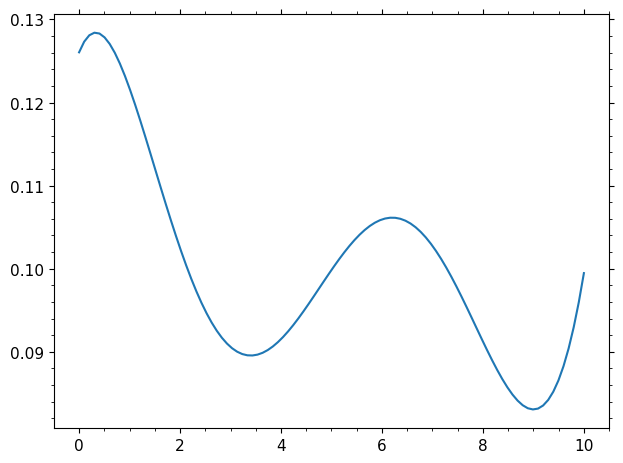

In [16]:
# define a p.d.f from Berstein stuff above

xrange = (0,10)

# pick some random Bernstein parameters
ps = [0.52420485, 0.61562272, 0.16032515, 0.19507356, 0.7592902,  0.46579071, 0.19310727, 0.4136769 ]

# Bernstein range
def pdf(x):
    y = (x - xrange[0]) / (xrange[1] - xrange[0])
    return bernstein(y, ps) / (xrange[1] - xrange[0])
    
x = np.linspace(*xrange,100)
plt.plot(x, pdf(x) )

In [17]:
# get the max-value in y
from scipy.optimize import brute
f = lambda x: -pdf(x)
x = brute(f, [xrange])
ymax = -f( x[0] )
print(ymax)

0.1284202648576171


In [18]:
def gen_accept_reject(size=1):
    res = []
    while len(res)<size:
        a = np.random.uniform(*xrange)
        b = np.random.uniform(0,ymax)
        y = pdf(a)
        if y > ymax:
            print('Some issue: as y larger than ymax')
        if b <= y:
            res.append(a)
    return res  

In [19]:
v = gen_accept_reject(size=5000)

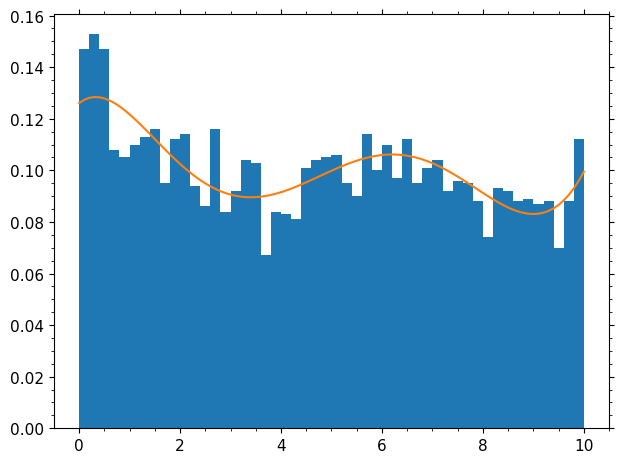

In [20]:
x = np.linspace(*xrange,100)
plt.hist(v, range=xrange, bins=50, density=True)
plt.plot(x, pdf(x))


# End of Lecture 7

By the end of this lecture you should:
   - Have more distributions in your armoury (the exponential distribution, Bernstein polynomials, the chi-squared distribution)
   - Sums of p.d.f.s
   - Convolutions of p.d.f.s
   - Understand and be able to deploy and contrast different methods of simulation from distributions
    